## Download images into colab 

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1f7uslI-ZHidriQFZR966_aILjlkgDN76',
                                    dest_path='content/eye_gender_data.zip',
                                    unzip=True)

Unzipping...Done.


## Import libraries

In [2]:
import pandas as pd                                     
import numpy as np                                      
import tensorflow as tf                                 
import os                                               
import cv2                                              
import matplotlib.pyplot as plt

## Loading and preparing training data


In [3]:
labels = pd.read_csv("/content/content/eye_gender_data/Training_set.csv")   # loading the labels
file_paths = [[fname, '/content/content/eye_gender_data/train/' + fname] for fname in labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')

data = []     
image_size = 32      # image size taken is 32 here. 

for i in range(len(train_data)):
  
  img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale
  new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array
  data.append(new_img_array) 

## Data Pre-processing
It is necessary to bring all the images to the same shape and size as defined by the VGG-19 model. Also, convert all the labels from categorical to numerical values.

In [4]:
arr = np.array(data)

In [5]:
arr

array([[[189, 188, 182, ..., 178, 177, 172],
        [187, 179, 179, ..., 175, 172, 162],
        [185, 181, 184, ..., 168, 157, 149],
        ...,
        [142, 136, 148, ..., 164, 162, 164],
        [140, 150, 161, ..., 169, 164, 164],
        [139, 154, 163, ..., 173, 167, 164]],

       [[170, 175, 172, ..., 190, 193, 194],
        [165, 152, 136, ..., 186, 189, 191],
        [147, 124, 107, ..., 183, 189, 193],
        ...,
        [188, 189, 190, ..., 191, 197, 202],
        [187, 190, 190, ..., 195, 197, 196],
        [186, 190, 190, ..., 200, 201, 197]],

       [[176, 172, 172, ..., 135, 128, 127],
        [168, 165, 165, ...,  91, 114, 111],
        [164, 165, 162, ...,  76,  62,  68],
        ...,
        [131, 143, 148, ..., 115, 112, 103],
        [131, 145, 150, ..., 113, 108,  99],
        [130, 144, 150, ..., 114, 106,  95]],

       ...,

       [[190, 175, 169, ..., 100, 115, 135],
        [177, 161, 147, ...,  83, 103, 101],
        [158, 138, 130, ...,  74,  72,  64

In [6]:
arr.shape

(9220, 32, 32)

In [7]:
# reshape into 3 channels for feeding into the model
train_images_3ch = np.stack([arr]*3, axis=-1)
print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))


Train_images.shape: (9220, 32, 32, 3), of uint8


In [8]:
# normalisation
train_images_scaled = train_images_3ch / 255.

In [9]:
# encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels = le.fit_transform(train_data[['label']])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
train_labels.shape

(9220,)

## Building Model & Hyperparameter tuning


In [11]:
# Build VGG19 Model

# define input shape
INPUT_SHAPE = (32, 32, 3)

# get the VGG19 model
vgg_layers = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, 
                                               input_shape=INPUT_SHAPE) 

vgg_layers.summary()

80142336/80134624 [==============================] - 2s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

In [12]:
# Fine-tune all the layers
for layer in vgg_layers.layers:
    layer.trainable = True 

# Check the trainable status of the individual layers
for layer in vgg_layers.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f2045f956d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2045d3b750> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2045cdcb50> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f2045c59e50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2045c82610> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f20424abc50> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f2045c801d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f20424b2d50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f20424bc510> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f20424c1910> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f20424b2c10> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f20424ce

In [13]:
# Build CNN model on top of VGG19

# define sequential model
model = tf.keras.models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_layers)

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #single node with ‘sigmoid‘ activation

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

In [14]:
EPOCHS = 30

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(train_images_scaled, train_labels,
                    batch_size=256,
                    callbacks=[es_callback], 
                    validation_split=0.1, epochs=EPOCHS, 
                    verbose=1)

Epoch 1/30
33/33 [==============================] - 1045s 32s/step - loss: 0.5705 - accuracy: 0.6972 - val_loss: 0.3879 - val_accuracy: 0.8384
Epoch 2/30
33/33 [==============================] - 1043s 32s/step - loss: 0.3877 - accuracy: 0.8386 - val_loss: 0.4051 - val_accuracy: 0.8265
Epoch 3/30
33/33 [==============================] - 1039s 31s/step - loss: 0.2899 - accuracy: 0.8843 - val_loss: 0.2550 - val_accuracy: 0.8991
Epoch 4/30
33/33 [==============================] - 1056s 32s/step - loss: 0.2262 - accuracy: 0.9091 - val_loss: 0.2357 - val_accuracy: 0.9100
Epoch 5/30
33/33 [==============================] - 1053s 32s/step - loss: 0.1916 - accuracy: 0.9243 - val_loss: 0.2271 - val_accuracy: 0.9111
Epoch 6/30
33/33 [==============================] - 1029s 31s/step - loss: 0.1690 - accuracy: 0.9359 - val_loss: 0.2162 - val_accuracy: 0.9230
Epoch 7/30
33/33 [==============================] - 1015s 31s/step - loss: 0.1520 - accuracy: 0.9422 - val_loss: 0.2118 - val_accuracy: 0.9132

## Validate the model


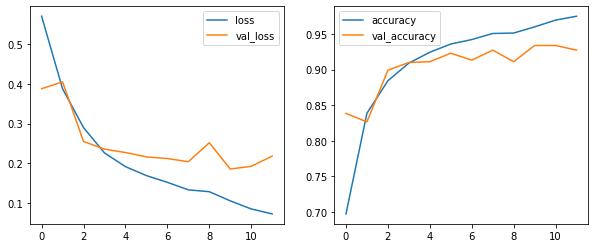

In [15]:
# Plot Learning Curves
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [16]:
# saving the model
save_dir = "/results/"
model_name = 'eye_model.h5'
model.save(model_name)
model_path = save_dir + model_name
print('Saved trained model at %s ' % model_path)

Saved trained model at /results/eye_model.h5 


## Predict The Output For Testing Dataset

## Load Test Set

In [17]:
test_data = pd.read_csv("/content/content/eye_gender_data/Testing_set.csv" )
file_paths_test = [[fname, '/content/content/eye_gender_data/test/' + fname] for fname in test_data['filename']]
images_test = pd.DataFrame(file_paths_test, columns=['filename', 'filepaths'])

new_test_data = []
#image_size = 32 

for i in range(len(images_test)):
  
  img_array_test = cv2.imread(images_test['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale
  new_img_array_test = cv2.resize(img_array_test, (image_size, image_size))      # resizing the image array
  new_test_data.append(new_img_array_test)

## Data Pre-processing on test_data


In [18]:
test_arr = np.array(new_test_data)

In [ ]:
test_arr

array([[[138, 140, 142, ..., 162, 167, 168],
        [140, 134, 137, ..., 159, 162, 161],
        [115, 131, 127, ..., 159, 158, 153],
        ...,
        [151, 164, 171, ..., 171, 159, 157],
        [147, 159, 165, ..., 166, 159, 154],
        [151, 160, 168, ..., 161, 150, 148]],

       [[163, 172, 156, ...,  84,  93,  85],
        [148, 158, 144, ...,  77,  75,  69],
        [136, 142, 128, ...,  67,  66,  68],
        ...,
        [114, 109, 108, ..., 129, 134, 144],
        [116, 119, 124, ..., 120, 134, 136],
        [112, 124, 123, ..., 120, 131, 122]],

       [[206, 200, 193, ..., 169, 176, 184],
        [205, 203, 186, ..., 171, 175, 180],
        [201, 202, 183, ..., 150, 156, 164],
        ...,
        [216, 218, 215, ..., 211, 214, 218],
        [215, 217, 218, ..., 215, 219, 222],
        [212, 217, 217, ..., 214, 220, 221]],

       ...,

       [[146, 149, 151, ..., 139, 142, 143],
        [150, 151, 155, ..., 139, 140, 140],
        [151, 150, 154, ..., 138, 139, 138

In [19]:
test_arr.shape

(2305, 32, 32)

In [20]:
# reshape into 3 channels for feeding into the model
test_images_3ch = np.stack([test_arr]*3, axis=-1)
print('\nTest_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Test_images.shape: (2305, 32, 32, 3), of uint8


In [21]:
# normalisation
test_images_scaled = test_images_3ch / 255.

## Make Prediction on Test Dataset

In [22]:
test_predictions = model.predict(test_images_scaled)

In [23]:
images_test['predictprobability'] = test_predictions

In [24]:
def convert_to_label (row):
  if row['predictprobability'] >=0.5:
    return 'male'
  else:
    return 'female'

images_test['predictlabel'] = images_test.apply(convert_to_label, axis=1)

In [25]:
images_test.head()

,filename,filepaths,predictprobability,predictlabel
0,Image_1.jpg,/content/content/eye_gender_data/test/Image_1.jpg,0.999559,male
1,Image_2.jpg,/content/content/eye_gender_data/test/Image_2.jpg,0.939506,male
2,Image_3.jpg,/content/content/eye_gender_data/test/Image_3.jpg,0.992196,male
3,Image_4.jpg,/content/content/eye_gender_data/test/Image_4.jpg,0.995121,male
4,Image_5.jpg,/content/content/eye_gender_data/test/Image_5.jpg,0.999794,male


In [26]:
images_test.tail()

,filename,filepaths,predictprobability,predictlabel
2300,Image_2301.jpg,/content/content/eye_gender_data/test/Image_23...,0.015451,female
2301,Image_2302.jpg,/content/content/eye_gender_data/test/Image_23...,0.004437,female
2302,Image_2303.jpg,/content/content/eye_gender_data/test/Image_23...,0.999947,male
2303,Image_2304.jpg,/content/content/eye_gender_data/test/Image_23...,0.999949,male
2304,Image_2305.jpg,/content/content/eye_gender_data/test/Image_23...,0.917629,male


In [27]:
# Save prediction results locally via colab notebook
images_test.to_csv("images_test.csv", index = False) 

# To download the csv file locally
from google.colab import files        
files.download('images_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>